# Let's train a Mixture of Experts (MoE) model using Hugging Face 🤗 

Welcome to the Mixture of Experts (MoE) training example notebook! We introduce the first Mixture of Expert (MoE) model that has been developped by Google AI in the paper ["Switch Transformers: Scaling to Trillion Parameter Models with Simple and Efficient Sparsity"](https://arxiv.org/abs/2101.03961).

The architecture of the model is pretty much similar to T5 models, with the FeedForward layer of the attention layer being slightly different. For the encoder and decoder model, the latest is replaced by "Sparse MLP". The figure below is taken from the original paper.
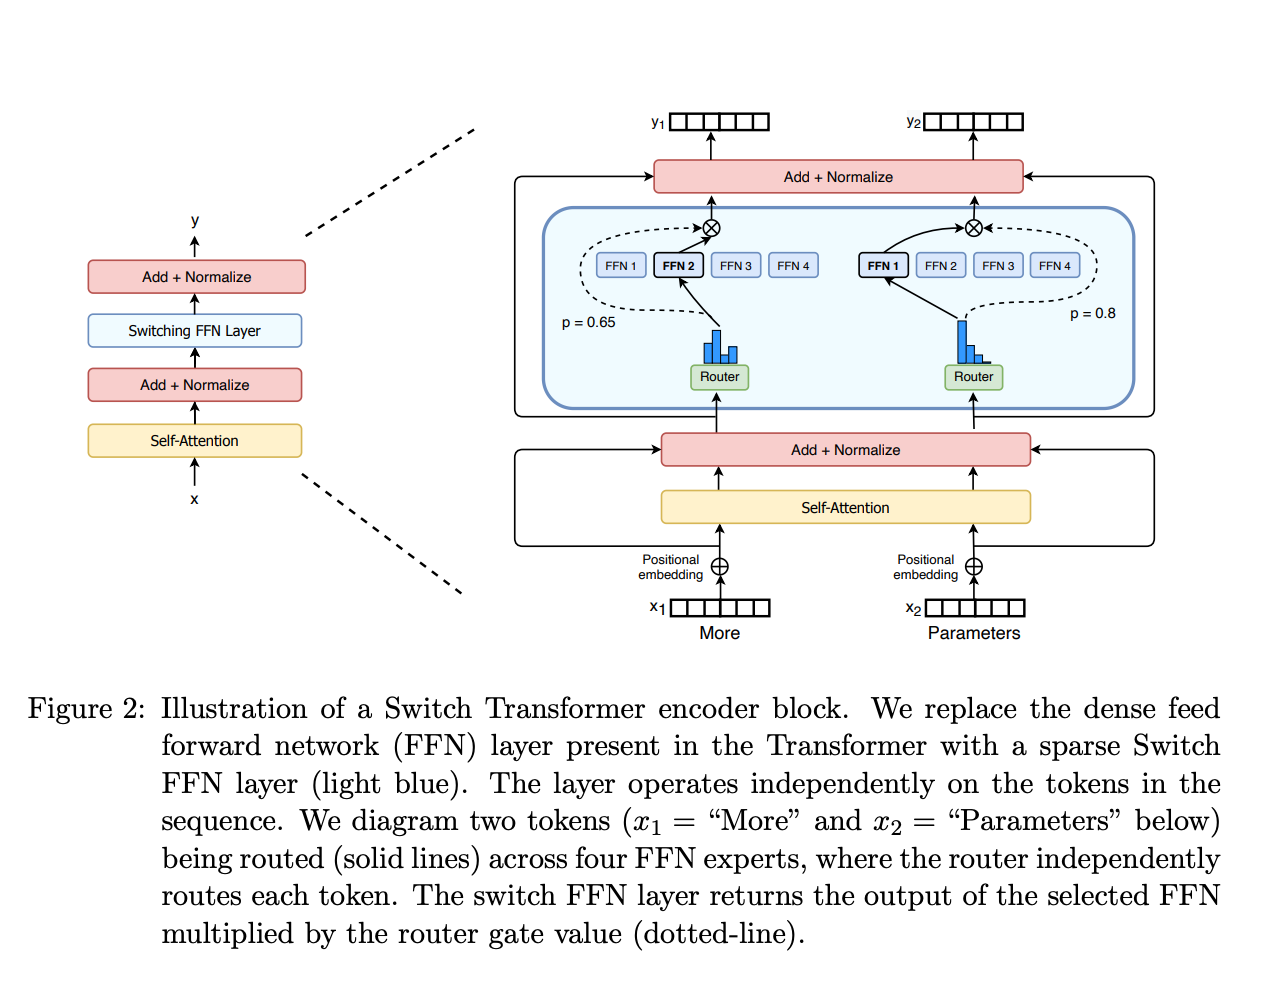

The pre-trained models have been recently converted and added to the Hub, let's try to fine-tune the smallest model on text summarization! 

This notebook has been adapted from the excellent notebook from [@abhimishra91](https://github.com/abhimishra91) that can be found [here](https://github.com/abhimishra91/transformers-tutorials/blob/master/transformers_summarization_wandb.ipynb)

## Install dependencies

In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git@main
!pip install -q accelerate
!pip install -q datasets
!pip install wandb -q
!pip install sentencepiece -q
%mkdir output

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 163 kB 4.4 MB/s 
     |████████████████████████████████| 7.6 MB 41.8 MB/s 
     |████████████████████████████████| 175 kB 4.7 MB/s 
     |████████████████████████████████| 451 kB 4.5 MB/s 
     |████████████████████████████████| 212 kB 80.1 MB/s 
     |████████████████████████████████| 115 kB 91.9 MB/s 
     |████████████████████████████████| 127 kB 85.3 MB/s 
     |████████████████████████████████| 1.9 MB 4.6 MB/s 
     |████████████████████████████████| 168 kB 77.6 MB/s 
     |████████████████████████████████| 182 kB 86.0 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
     |████████████████████████████████| 166 kB 90.6 MB/s 
     |████████████████████████████████| 166 kB 93.5 MB/s 
     |████████████████████████████████| 162 kB 84.1 MB/s 
     |████████████████████████████████| 162 kB 88.5 MB/s 
     |████

## Import Libraries

In [ ]:
# Importing stock libraries
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler

# Importing the T5 modules from huggingface/transformers
from transformers import T5Tokenizer, T5ForConditionalGeneration

# WandB – Import the wandb library
import wandb

In [ ]:
# # Setting up the device for GPU usage
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

Don't forget to login on `wandb` by running the cell below!

In [ ]:
# Login to wandb to log the model run and all the parameters
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Here we define our custom Dataset class:

In [ ]:
# Creating a custom dataset for reading the dataframe and loading it into the dataloader to pass it to the neural network at a later stage for finetuning the model and to prepare it for predictions

class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, source_len, summ_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.source_len = source_len
        self.summ_len = summ_len
        self.context = self.data["document"]
        self.summaries = self.data["summary"]

    def __len__(self):
        return len(self.context)

    def __getitem__(self, index):
        context = self.context[index]
        summary = self.summaries[index]

        source = self.tokenizer.batch_encode_plus([context], max_length= self.source_len, pad_to_max_length=True,return_tensors='pt')
        target = self.tokenizer.batch_encode_plus([summary], max_length= self.summ_len, pad_to_max_length=True,return_tensors='pt')

        source_ids = source['input_ids'].squeeze()
        source_mask = source['attention_mask'].squeeze()
        target_ids = target['input_ids'].squeeze()
        target_mask = target['attention_mask'].squeeze()

        return {
            'source_ids': source_ids.to(dtype=torch.long), 
            'source_mask': source_mask.to(dtype=torch.long), 
            'target_ids': target_ids.to(dtype=torch.long),
            'target_ids_y': target_ids.to(dtype=torch.long)
        }

## Training and validation loop

Below is the definition of our main training loop

In [ ]:
# Creating the training function. This will be called in the main function. It is run depending on the epoch value.
# The model is put into train mode and then we wnumerate over the training loader and passed to the defined network 

def train(epoch, tokenizer, model, device, loader, optimizer):
    model.train()
    for _,data in enumerate(loader, 0):
        labels = data['target_ids'].to(device, dtype = torch.long)
        labels = model._shift_right(labels)

        # We set the pad tokens (0) to -100 to be
        # ignored by the CrossEntropy loss
        labels = labels.masked_fill_(labels == 0, -100)
        ids = data['source_ids'].to(device, dtype = torch.long)
        mask = data['source_mask'].to(device, dtype = torch.long)
        decoder_input_ids = torch.zeros_like(labels).long()

        outputs = model(input_ids = ids, attention_mask = mask, labels=labels, output_router_logits=True, return_dict=True)
        loss = outputs[0]
        
        if _%10 == 0:
            wandb.log({"Training Loss": loss.item()})
            wandb.log({"Training Encoder z-Loss": outputs.encoder_z_loss.item()})
            wandb.log({"Training Encoder aux-Loss": outputs.encoder_aux_loss.item()})
            wandb.log({"Training Decoder z-Loss": outputs.decoder_z_loss.item()})
            wandb.log({"Training Decoder aux-Loss": outputs.decoder_aux_loss.item()})

        if _%500==0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')

        if (_ + 1) %2000==0:
          break
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # xm.optimizer_step(optimizer)
        # xm.mark_step()

And validation loop!

In [ ]:
def validate(epoch, tokenizer, model, device, loader):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for _, data in enumerate(loader, 0):
            y = data['target_ids'].to(device, dtype = torch.long)
            ids = data['source_ids'].to(device, dtype = torch.long)
            mask = data['source_mask'].to(device, dtype = torch.long)

            generated_ids = model.generate(
                input_ids = ids,
                attention_mask = mask, 
                max_length=150, 
                num_beams=2,
                repetition_penalty=2.5, 
                length_penalty=1.0, 
                early_stopping=True
                )
            preds = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in generated_ids]
            target = [tokenizer.decode(t, skip_special_tokens=True, clean_up_tokenization_spaces=True)for t in y]
            if _%100==0:
                print(f'Completed {_}')
                break

            predictions.extend(preds)
            actuals.extend(target)
    return predictions, actuals

## Main loop

Below is the main script for training and validation, the trained model will be saved after `TRAIN_EPOCHS` iterations!

In [ ]:
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoConfig, SwitchTransformersForConditionalGeneration

def main():
    # WandB – Initialize a new run
    wandb.init(project="transformers_tutorials_summarization")

    # WandB – Config is a variable that holds and saves hyperparameters and inputs
    # Defining some key variables that will be used later on in the training  
    config = wandb.config          # Initialize config
    config.TRAIN_BATCH_SIZE = 16    # input batch size for training (default: 64)
    config.VALID_BATCH_SIZE = 16    # input batch size for testing (default: 1000)
    config.TRAIN_EPOCHS = 1        # number of epochs to train (default: 10)
    config.VAL_EPOCHS = 1 
    config.LEARNING_RATE = 1e-4    # learning rate (default: 0.01)
    config.SEED = 42               # random seed (default: 42)
    config.MAX_LEN = 256
    config.SUMMARY_LEN = 80
    


    # Set random seeds and deterministic pytorch for reproducibility
    torch.manual_seed(config.SEED) # pytorch random seed
    np.random.seed(config.SEED) # numpy random seed
    torch.backends.cudnn.deterministic = True

    # tokenzier for encoding the text
    tokenizer = AutoTokenizer.from_pretrained("google/switch-base-8")

    dataset = load_dataset("xsum")
    def preprend(example):
      return {"document":["summarize: "+ x for x in example["document"]]}
    encoded_dataset = dataset.map(preprend, batched=True)

    
    # Creation of Dataset and Dataloader
    # Defining the train size. So 80% of the data will be used for training and the rest will be used for validation. 
    train_dataset=encoded_dataset["train"]
    val_dataset=encoded_dataset["validation"]


    # Creating the Training and Validation dataset for further creation of Dataloader
    training_set = CustomDataset(train_dataset, tokenizer, config.MAX_LEN, config.SUMMARY_LEN)
    val_set = CustomDataset(val_dataset, tokenizer, config.MAX_LEN, config.SUMMARY_LEN)

    # Defining the parameters for creation of dataloaders
    train_params = {
        'batch_size': config.TRAIN_BATCH_SIZE,
        'shuffle': True,
        'num_workers': 0
        }

    val_params = {
        'batch_size': config.VALID_BATCH_SIZE,
        'shuffle': False,
        'num_workers': 0
        }

    # Creation of Dataloaders for testing and validation. This will be used down for training and validation stage for the model.
    training_loader = DataLoader(training_set, **train_params)
    val_loader = DataLoader(val_set, **val_params)
    
    # Defining the model. We are using t5-base model and added a Language model layer on top for generation of Summary. 
    # Further this model is sent to device (GPU/TPU) for using the hardware.
    model = SwitchTransformersForConditionalGeneration.from_pretrained("google/switch-base-8", torch_dtype=torch.bfloat16)


    model = model.to(device)

    # Defining the optimizer that will be used to tune the weights of the network in the training session. 
    optimizer = torch.optim.Adam(params =  model.parameters(), lr=config.LEARNING_RATE)

    # Log metrics with wandb
    wandb.watch(model, log="all")
    # Training loop
    print('Initiating Fine-Tuning for the model on our dataset')

    for epoch in range(config.TRAIN_EPOCHS):
        train(epoch, tokenizer, model, device, training_loader, optimizer)


    # Validation loop and saving the resulting file with predictions and acutals in a dataframe.
    # Saving the dataframe as predictions.csv
    print('Now generating summaries on our fine tuned model for the validation dataset and saving it in a dataframe')
    for epoch in range(config.VAL_EPOCHS):
        predictions, actuals = validate(epoch, tokenizer, model, device, val_loader)
        final_df = pd.DataFrame({'Generated Text':predictions,'Actual Text':actuals})
        final_df.to_csv('./output/predictions.csv')
        print('Output Files generated for review')
    return model, tokenizer

trained_model, tokenizer = main()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: artzucker. Use `wandb login --relogin` to force relogin


Downloading:   0%|          | 0.00/2.35k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/204045 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11332 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11334 [00:00<?, ? examples/s]

Dataset xsum downloaded and prepared to /root/.cache/huggingface/datasets/xsum/default/1.2.0/32c23220eadddb1149b16ed2e9430a05293768cfffbdfd151058697d4c11f934. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/205 [00:00<?, ?ba/s]

  0%|          | 0/12 [00:00<?, ?ba/s]

  0%|          | 0/12 [00:00<?, ?ba/s]

Downloading:   0%|          | 0.00/1.86k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.24G [00:00<?, ?B/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Initiating Fine-Tuning for the model on our dataset


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Epoch: 0, Loss:  26.714859008789062
Epoch: 0, Loss:  3.3135790824890137
Epoch: 0, Loss:  2.765906572341919
Epoch: 0, Loss:  2.909602642059326
Now generating summaries on our fine tuned model for the validation dataset and saving it in a dataframe
Completed 0
Output Files generated for review


This cell will take quite some time to run it until it ends, so we have just ran it on few steps and pushed the saved model on the Hub so that you can play with it! 

We also advise you to change the training hyper-parameters so that it can fit the 16GB Google Colab (the training was run using Colab pro)

If you are interested, you can have a look at the training logs [here](https://wandb.ai/artzucker/transformers_tutorials_summarization?workspace=user-artzucker)



# Test the model

## Download the trained model

We have pushed on the Hub the model that has been trained for this experiment! You can download it using the commands below - use it without moderation 🤗:

In [ ]:
from transformers import AutoTokenizer, SwitchTransformersForConditionalGeneration

trained_model = SwitchTransformersForConditionalGeneration.from_pretrained("ybelkada/switch-base-8-xsum", torch_dtype=torch.bfloat16)
tokenizer = AutoTokenizer.from_pretrained("ybelkada/switch-base-8-xsum")

Downloading:   0%|          | 0.00/1.97k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.24G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.35k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

## Generate some text!

After training the model for few steps (below is the result of a model trained for ~2000 steps! The model will be probably much better if it has been trained longer and on longer sequences.

In [ ]:
text = "summarize: Peter and Elizabeth took a taxi to attend the night party in the city. While in the party, Elizabeth collapsed and was rushed to the hospital. Since she was diagnosed with a brain injury, the doctor told Peter to stay besides her until she gets well. Therefore, Peter stayed with her at the hospital for 3 days without leaving."

input_ids = tokenizer(text, return_tensors="pt").input_ids
output_ids = trained_model.generate(input_ids)

print(tokenizer.decode(output_ids[0], decoder_input_ids=[0], skip_special_tokens=False))

/usr/local/lib/python3.7/dist-packages/transformers/generation/utils.py:1392: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 20 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  UserWarning,


<pad> Peter and Elizabeth were in a party in Paris.</s>


The summarization could be probably better, but the model has caught some context from the input sentence and sumarized quite nicely the context (for a small model trained on few steps :D) 

## Push your model to the Hub!

If you want to push your model to the Hugging Face Hub, first make sure that you are logged in using the `huggingface-cli` API:

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
repo_name = "YOUR_REPO_NAME"

trained_model.push_to_hub(repo_name)